
## Libraries


In [1]:
import random

# data manipulation libraries
import numpy as np
import pandas as pd

# machine learning libraries
import xgboost as xgb

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

# deep learning libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import heatmap

# deployment libraries
import onnxruntime as rt
import onnxmltools
from skl2onnx.common.data_types import FloatTensorType


## Parameters 


In [2]:
batch_size = 32
learning_rate = 0.001
N_Epochs = 1000
epsilon = 0.0001


## Read data


In [3]:
path_data = '../data/Sleep_health_and_lifestyle_dataset.csv'
SLEEP_RAW_DATA = pd.read_csv(path_data, low_memory=False)

print("Shape of SLEEP_RAW_DATA:", SLEEP_RAW_DATA.shape)
SLEEP_RAW_DATA.head()

Shape of SLEEP_RAW_DATA: (374, 13)


,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [4]:
SLEEP_RAW_DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB


In [5]:
SLEEP_DATA = SLEEP_RAW_DATA.copy()
SLEEP_DATA['Sleep Disorder'] = SLEEP_DATA['Sleep Disorder'].fillna('No Disorder')
SLEEP_DATA['Sleep Disorder'].value_counts()

Sleep Disorder
No Disorder    219
Sleep Apnea     78
Insomnia        77
Name: count, dtype: int64

In [6]:
# No null values
SLEEP_DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           374 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB


In [7]:
headers_list = SLEEP_DATA.columns.values.tolist()
headers_list

['Person ID',
 'Gender',
 'Age',
 'Occupation',
 'Sleep Duration',
 'Quality of Sleep',
 'Physical Activity Level',
 'Stress Level',
 'BMI Category',
 'Blood Pressure',
 'Heart Rate',
 'Daily Steps',
 'Sleep Disorder']

In [8]:
def convert_categorical_to_numerical(df, column_name):
	df[column_name] = df[column_name].astype('category').cat.codes
	return df

# convert all categorical columns to numerical
categorical_columns = SLEEP_DATA.select_dtypes(include=['object']).columns
for col in categorical_columns:
	SLEEP_DATA = convert_categorical_to_numerical(SLEEP_DATA, col)

In [9]:
SLEEP_DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    int8   
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    int8   
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    int8   
 9   Blood Pressure           374 non-null    int8   
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           374 non-null    int8   
dtypes: float64(1), int64(7), int8(5)
memory usage: 25.3 KB



## Data Analysis

* Correlation matrix


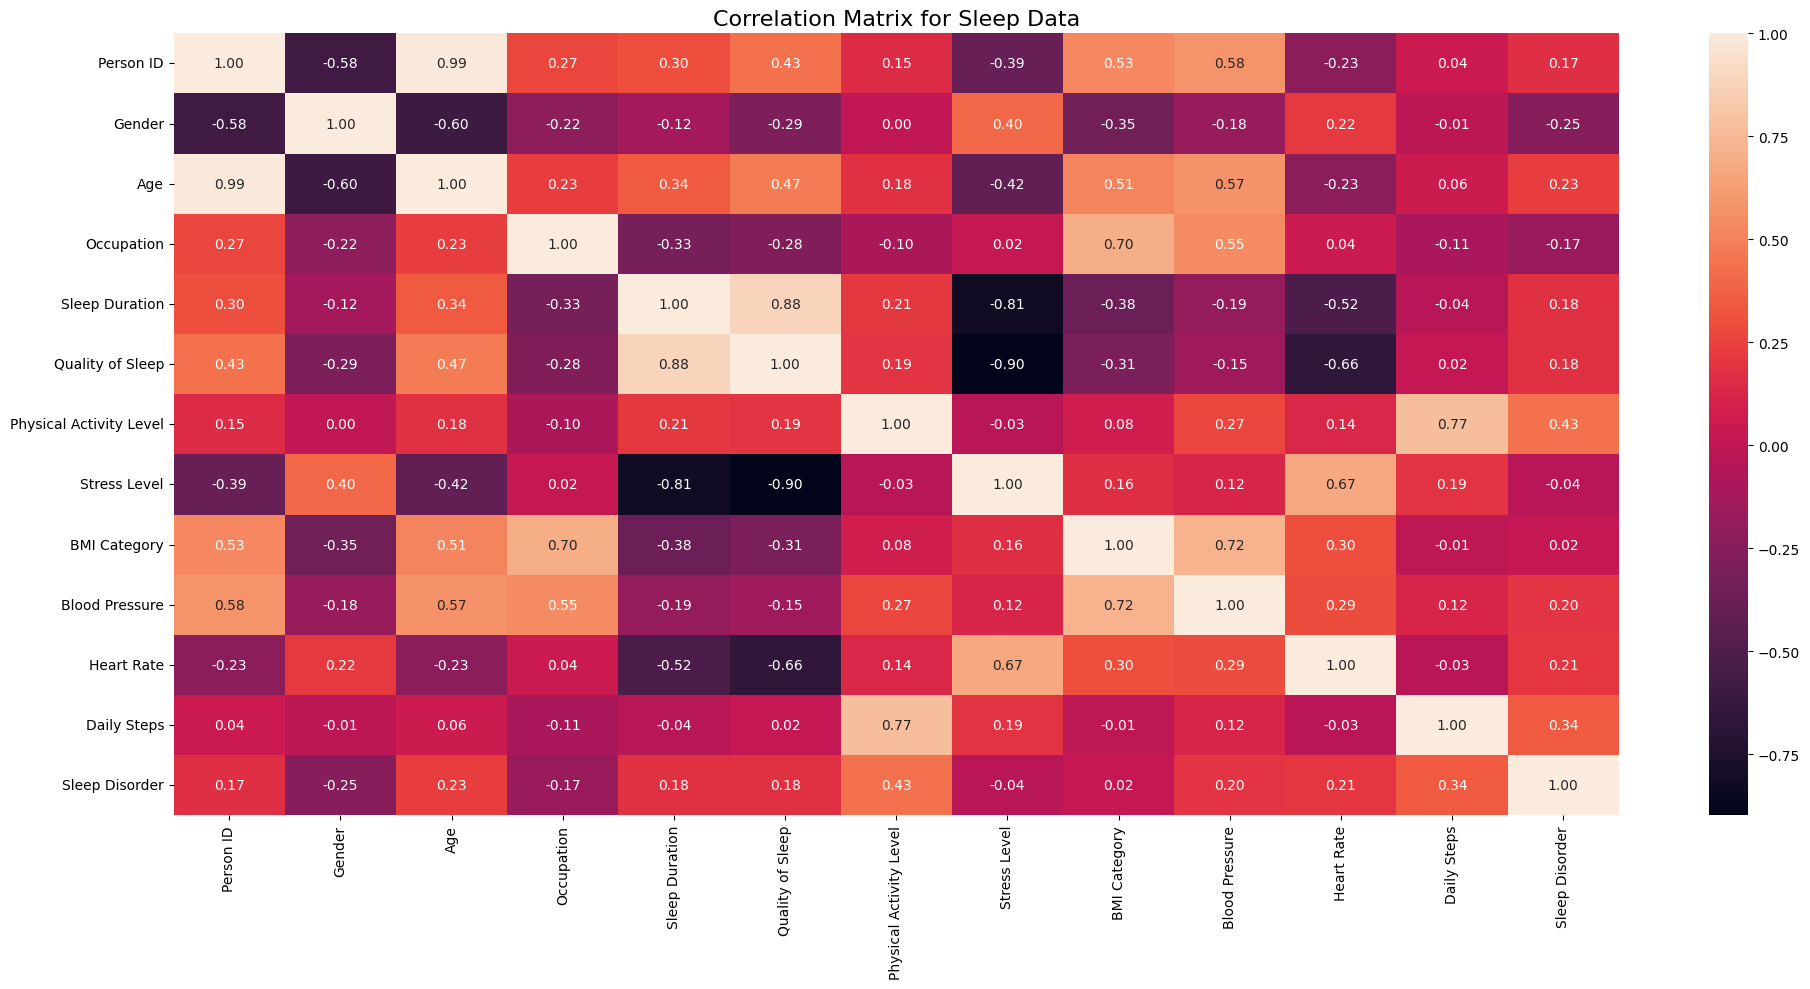

In [10]:
# Correlation matrix
plt.figure(figsize=(20,10))
sns.heatmap(SLEEP_DATA.corr(), annot=True, fmt=".2f")
plt.title("Correlation Matrix for Sleep Data", fontsize=16)
plt.tight_layout()
plt.show()


## Process Data


In [11]:
SLEEP_DATA_np = SLEEP_DATA.to_numpy()
SLEEP_DATA_np

array([[1.00e+00, 1.00e+00, 2.70e+01, ..., 7.70e+01, 4.20e+03, 1.00e+00],
       [2.00e+00, 1.00e+00, 2.80e+01, ..., 7.50e+01, 1.00e+04, 1.00e+00],
       [3.00e+00, 1.00e+00, 2.80e+01, ..., 7.50e+01, 1.00e+04, 1.00e+00],
       ...,
       [3.72e+02, 0.00e+00, 5.90e+01, ..., 6.80e+01, 7.00e+03, 2.00e+00],
       [3.73e+02, 0.00e+00, 5.90e+01, ..., 6.80e+01, 7.00e+03, 2.00e+00],
       [3.74e+02, 0.00e+00, 5.90e+01, ..., 6.80e+01, 7.00e+03, 2.00e+00]])

In [12]:
SLEEP_DATA_np.shape

(374, 13)

In [13]:
X = SLEEP_DATA_np[:, :-1]
y = SLEEP_DATA_np[:, -1]

In [14]:
y = y.astype(int)
y

array([1, 1, 1, 2, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1,

In [15]:
the_set = np.unique(y)
the_set

array([0, 1, 2])

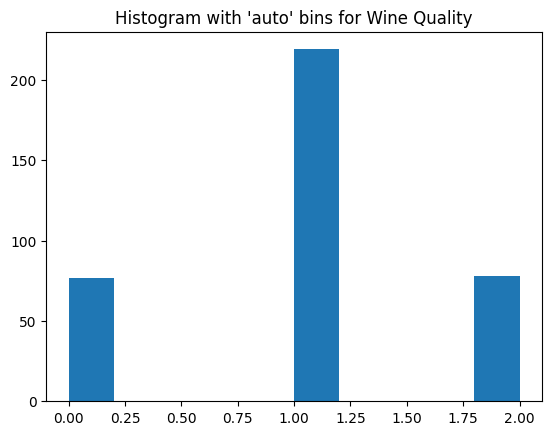

In [16]:
_ = plt.hist(y, bins='auto') 
plt.title("Histogram with 'auto' bins for Wine Quality")
plt.show()


In [17]:
print(X.shape)
print(y.shape)

(374, 12)
(374,)


In [18]:
random_seed = int( random.random() * 100 )
random_seed

25

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [20]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(299, 12)
(75, 12)
(299,)
(75,)


In [21]:
X_test.dtype, y_test.dtype

(dtype('float64'), dtype('int32'))


## Fix in case float64 error


In [22]:
# fix data type
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)

In [23]:
X_train_tr = torch.from_numpy(X_train)
X_test_tr  = torch.from_numpy(X_test)
y_train_tr = torch.from_numpy(y_train)
y_test_tr  = torch.from_numpy(y_test)


## Normalization

* Normalizartion
* Standardization (*)


In [24]:
x_means      = X_train_tr.mean(0, keepdim=True ) 
x_deviations = X_train_tr.std( 0, keepdim=True) + epsilon

In [25]:
x_means

tensor([[1.8441e+02, 5.2174e-01, 4.1943e+01, 3.6756e+00, 7.1492e+00, 7.3445e+00,
         5.8512e+01, 5.3211e+00, 1.2375e+00, 1.2846e+01, 6.9903e+01, 6.7860e+03]])

In [26]:
x_deviations

tensor([[1.0789e+02, 5.0046e-01, 8.6712e+00, 3.0376e+00, 7.9240e-01, 1.1922e+00,
         2.0666e+01, 1.7545e+00, 1.4333e+00, 6.9445e+00, 3.8973e+00, 1.5511e+03]])


## Create the DataLoader


In [27]:
train_list = [(X_train[i], y_train[i]) for i in range(X_train.shape[0])]
test_list  = [(X_test[i],  y_test[i])  for i in range(X_test.shape[0])]

In [28]:
train_dl = torch.utils.data.DataLoader(train_list, batch_size=batch_size, shuffle=True)

In [29]:
all_test_data = X_test.shape[0]
test_dl  = torch.utils.data.DataLoader(test_list,  batch_size=all_test_data, shuffle=True)


## Neural Network Architectures


In [30]:
class MLP_Net(nn.Module):
    def __init__(self, x_means, x_deviations):
        super().__init__()

        self.x_means      = x_means
        self.x_deviations = x_deviations
        
        self.linear1 = nn.Linear(12, 5)
        self.act1    = nn.ReLU()   ## nn.Sigmoid()
        self.linear2 = nn.Linear(5, 3)
        self.act2    = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.25)

    ## perform inference
    def forward(self, x):
        x      = (x - self.x_means) / self.x_deviations
        x      = self.linear1(x)
        x      = self.act1(x)
        x      = self.dropout(x)
        x      = self.linear2(x)
        y_pred = self.act2(x)
        
        return y_pred

In [31]:
class DL_Net(nn.Module):
    """Deep Learning network with 2 hidden layers"""
    
    def __init__(self, x_means, x_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        
        self.linear1 = nn.Linear(12, 15)
        self.act1    = nn.ReLU()
        self.linear2 = nn.Linear(15, 9)
        self.act2    = nn.ReLU()
        self.linear3 = nn.Linear(9, 3)
        self.act3    = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.25)
        
    ## perform inference
    def forward(self, x):
        
        x      = (x - self.x_means) / self.x_deviations
        
        x      = self.linear1(x)
        x      = self.act1(x)
        x      = self.dropout(x)
        x      = self.linear2(x)
        x      = self.act2(x)
        x      = self.dropout(x)
        x      = self.linear3(x)
        y_pred = self.act3(x)
        
        return y_pred


## Training Loop

In [32]:
def training_loop(N_Epochs, model, loss_fn, opt):

    for epoch in range(N_Epochs):
        for xb, yb in train_dl:
            # yb = torch.squeeze(yb, dim=1)

            y_pred = model(xb)
            # print(    yb.shape   )
            # print( y_pred.shape  )
            loss = loss_fn(y_pred, yb)

            opt.zero_grad()
            loss.backward()
            opt.step()

        if epoch % 50 == 0:
            print(epoch, "loss=", loss)

In [33]:
def print_metrics_function(y_test, y_pred):
    print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print("Confusion Matrix:")
    print(confmat)
    print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    print('F1-measure: %.3f' % f1_score(y_true=y_test, y_pred=y_pred, average='weighted'))

## Training the MLP Model

In [34]:
mlp_model = MLP_Net(x_means, x_deviations)

opt = torch.optim.Adam(mlp_model.parameters(), lr=learning_rate)

## the y_test data can be integers and does not need to be one hot encoded with this function
loss_fn = nn.CrossEntropyLoss()

training_loop(N_Epochs, mlp_model, loss_fn, opt)

0 loss= tensor(1.0775, grad_fn=<NllLossBackward0>)
50 loss= tensor(0.8096, grad_fn=<NllLossBackward0>)
100 loss= tensor(0.7610, grad_fn=<NllLossBackward0>)
150 loss= tensor(0.8294, grad_fn=<NllLossBackward0>)
200 loss= tensor(0.8521, grad_fn=<NllLossBackward0>)
250 loss= tensor(0.8705, grad_fn=<NllLossBackward0>)
300 loss= tensor(0.5815, grad_fn=<NllLossBackward0>)
350 loss= tensor(0.6337, grad_fn=<NllLossBackward0>)
400 loss= tensor(0.6626, grad_fn=<NllLossBackward0>)
450 loss= tensor(0.7336, grad_fn=<NllLossBackward0>)
500 loss= tensor(0.7404, grad_fn=<NllLossBackward0>)
550 loss= tensor(0.7464, grad_fn=<NllLossBackward0>)
600 loss= tensor(0.5985, grad_fn=<NllLossBackward0>)
650 loss= tensor(0.6823, grad_fn=<NllLossBackward0>)
700 loss= tensor(0.7228, grad_fn=<NllLossBackward0>)
750 loss= tensor(0.7302, grad_fn=<NllLossBackward0>)
800 loss= tensor(0.5820, grad_fn=<NllLossBackward0>)
850 loss= tensor(0.8140, grad_fn=<NllLossBackward0>)
900 loss= tensor(0.7571, grad_fn=<NllLossBackward

In [35]:
with torch.no_grad():
    for x_real, y_real in test_dl:
        y_pred = mlp_model(x_real)
        vals, indeces = torch.max(y_pred, dim=1)
        preds = indeces
        print_metrics_function(y_real, preds)

Accuracy: 0.73
Confusion Matrix:
[[14  0  4]
 [ 2 34  1]
 [12  1  7]]
Precision: 0.755
Recall: 0.733
F1-measure: 0.729



## Core Functions for Deep Learning


In [36]:
dl_model = DL_Net(x_means, x_deviations)
opt = torch.optim.Adam(dl_model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

training_loop(N_Epochs, dl_model, loss_fn, opt)

0 loss= tensor(1.0590, grad_fn=<NllLossBackward0>)
50 loss= tensor(0.6230, grad_fn=<NllLossBackward0>)
100 loss= tensor(0.5713, grad_fn=<NllLossBackward0>)
150 loss= tensor(0.5995, grad_fn=<NllLossBackward0>)
200 loss= tensor(0.6426, grad_fn=<NllLossBackward0>)
250 loss= tensor(0.6586, grad_fn=<NllLossBackward0>)
300 loss= tensor(0.6424, grad_fn=<NllLossBackward0>)
350 loss= tensor(0.6471, grad_fn=<NllLossBackward0>)
400 loss= tensor(0.6429, grad_fn=<NllLossBackward0>)
450 loss= tensor(0.6445, grad_fn=<NllLossBackward0>)
500 loss= tensor(0.5519, grad_fn=<NllLossBackward0>)
550 loss= tensor(0.8084, grad_fn=<NllLossBackward0>)
600 loss= tensor(0.7335, grad_fn=<NllLossBackward0>)
650 loss= tensor(0.6583, grad_fn=<NllLossBackward0>)
700 loss= tensor(0.6726, grad_fn=<NllLossBackward0>)
750 loss= tensor(0.6544, grad_fn=<NllLossBackward0>)
800 loss= tensor(0.6424, grad_fn=<NllLossBackward0>)
850 loss= tensor(0.6425, grad_fn=<NllLossBackward0>)
900 loss= tensor(0.6523, grad_fn=<NllLossBackward

In [37]:
with torch.no_grad():
    for x_real, y_real in test_dl:
        y_pred = dl_model(x_real)
        vals, indeces = torch.max(y_pred, dim=1)
        preds = indeces
        print_metrics_function(y_real, preds)

Accuracy: 0.89
Confusion Matrix:
[[13  0  5]
 [ 1 35  1]
 [ 0  1 19]]
Precision: 0.905
Recall: 0.893
F1-measure: 0.893


In [39]:
dl_model.eval()

DL_Net(
  (linear1): Linear(in_features=12, out_features=15, bias=True)
  (act1): ReLU()
  (linear2): Linear(in_features=15, out_features=9, bias=True)
  (act2): ReLU()
  (linear3): Linear(in_features=9, out_features=3, bias=True)
  (act3): Softmax(dim=1)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [41]:
dummy_input = torch.randn(1, 12)

input_names = ["input1"]
output_names = ["output1"]

torch.onnx.export(
    dl_model,
    dummy_input,
    "DLnet_sleep_classification.onnx",
    verbose=True,
    input_names=input_names,
    output_names=output_names

)

C:\Users\ikath\AppData\Local\Temp\ipykernel_27608\2543156490.py:6: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(
